# Fidelity Isn't Accuracy: When Linearly Decodable Functions Fail to Match the Ground Truth

The following code is from the paper *Fidelity Isn't Accuracy*. Please feel free to use and modify it however you'd like, but be sure to cite the paper!

## Abstract

In explainable AI, surrogate models are often evaluated by their fidelity to a neural network's predictions. Yet fidelity does not ensure accuracy on the underlying task---a gap that has received little formal attention. This work introduces the linearity score $\lambda(f)$, a diagnostic that quantifies how much of a regression network's behavior is linearly decodable. $\lambda(f)$ is defined as an $R^2$ measure of surrogate fit. Across synthetic and real-world regression datasets, surrogates are shown to achieve high fidelity to a neural network while failing to capture the predictive gains. In several cases, high-fidelity surrogates underperform even simple linear baselines. These findings reveal a fundamental limitation in treating fidelity as a proxy for task performance.

## Citation

Citation is withheld for double-blind review process.

## Table of Contents

1. Definition of Linearity Score $\lambda(f)$
2. Experimental Framework
3. **Experiment 1**: Synthetic Dataset ($x \cdot \sin x + \epsilon$)
4. **Experiment 2**: Medical Insurance Cost
6. **Experiment 3**: California Housing
7. Conclusion

## How to Use

To reproduce the published study, simply run all cells from top to bottom. To apply $\lambda(f)$ to your own data, add a cell and use the boilerplate to run your experiment.

## Dependencies

- Python 3.8+
- NumPy
- scikit-learn
- TensorFlow
- MatplotLib
- Pandas
- kagglehub
- seaborn

## License
This code is provided as-is, and all modification and redistribution of it is permitted as long as the original work is attributed correctly and clearly to the author.

In [11]:
%pip install numpy pandas seaborn matplotlib scikit-learn tensorflow kagglehub

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached kagglehub-0.4.1-py3-none-any.whl.metadata (38 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.12.19-py2.py3-none-any.whl.metadata (1.0 kB)
  Using cached gast-0.7.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.33.4-cp39-abi3-macosx_10_9_universal2.whl.metadata (593 bytes)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached termcolor-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.13.1-py3-none-any.whl.metadata (6.3 kB)
  Using cached kagg

In [12]:
## Imports ##

# General utilities
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn components
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Datasets
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.datasets import fetch_california_housing


## Setup ##

np.random.seed(42)
tf.random.set_seed(42)

/Users/test/Development/Lafayette/French Thesis/lambda-linearity-score/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Linearity Score $\lambda(f)$

This section provides a brief overview of $\lambda(f)$. For full details and motivation, please refer to the paper—especially Section 2.

Let $ \mathcal{L} $ denote the subspace of affine (linear) functions. Then define:

$$ \lambda(f) := R^2(f, g), \text{ where }  g = \arg\min_{g_i \in \mathcal{L}} \mathbb{E}_{x \sim \mathcal{D}} \left[(f(x) - g(x))^2\right] $$

Plainly, $\lambda(f)$ is the coefficient of determination ($R^2$ score) between a neural network $f$ and the best linear approximation $g$. Importantly, $g$ is chosen to approximate the outputs of the network $f$, not the original data. Thus, $\lambda(f)$ measures how well the learned function itself can be mimicked by a linear model, independent of ground truth.

In [13]:
def lambda_score(f_preds: np.ndarray, g_preds: np.ndarray) -> float:
    """
    Computes λ(f, g) = R^2(f(x), g(x)), i.e., how well g mimics f.

    Parameters:
    - f_preds: predictions from the neural network (f(x))
    - g_preds: predictions from the mimic linear model (g(x))

    Returns:
    - λ score (float): R^2 score between f_preds and g_preds
    """
    return r2_score(f_preds, g_preds)

## 2. Experimental Framework

The following code defines a standardized procedure for evaluating the linearity score $\lambda(f)$ across multiple datasets and model runs. Each experiment consists of:

- Training a baseline linear regression model.
- Training a neural network on the same data.
- Fitting a linear surrogate (the "mimic model") to approximate the neural network’s output.
- Computing $\lambda(f)$, the $R^2$ between the network's output and the surrogate.

This procedure is repeated multiple times to gather statistics (mean and standard deviation) on model performance and linear decodability.

You can easily adapt this framework to your own datasets or architectures by modifying the data inputs and network-building function.

In [14]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

def run_experiment(X_train, y_train, X_test, y_test, build_network, n=5):
    """
    Runs an experiment on given data using a compiled NN model returned by build_network().

    Parameters:
    - X_train, y_train: training data and labels
    - X_test, y_test: testing data and labels
    - build_network: a function that returns a compiled but untrained model
    - n: number of experiment repetitions
    """

    # Existing metrics (unchanged)
    baseline_scores = []
    nn_scores = []
    mimic_scores = []
    lambda_scores = []

    baseline_test_preds = []
    nn_test_preds = []
    mimic_test_preds = []

    # New: RMSE tracking (additive; won't impact prior experiments)
    baseline_rmse_scores = []
    nn_rmse_scores = []
    mimic_rmse_scores = []

    for _ in range(n):
        ### Baseline Linear Regression ###
        baseline_lr = LinearRegression()
        baseline_lr.fit(X_train, y_train)
        y_pred_lr = baseline_lr.predict(X_test)

        baseline_scores.append(r2_score(y_test, y_pred_lr))
        baseline_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_lr)))
        baseline_test_preds.append(y_pred_lr)

        ### Neural Network ###
        model = build_network()  # Create fresh model
        model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
        f_test = model.predict(X_test).flatten()

        nn_scores.append(r2_score(y_test, f_test))
        nn_rmse_scores.append(np.sqrt(mean_squared_error(y_test, f_test)))
        nn_test_preds.append(f_test)

        ### Mimic Model ###
        f_train = model.predict(X_train).flatten()
        mimic_lr = LinearRegression()
        mimic_lr.fit(X_train, f_train)
        g_test = mimic_lr.predict(X_test)

        mimic_scores.append(r2_score(y_test, g_test))
        mimic_rmse_scores.append(np.sqrt(mean_squared_error(y_test, g_test)))

        lambda_scores.append(lambda_score(f_test, g_test))
        mimic_test_preds.append(g_test)

    # Compute statistics (all old keys preserved; new keys added)
    stats = {
        # Existing summary stats
        'baseline_mean': np.mean(baseline_scores),
        'nn_mean': np.mean(nn_scores),
        'mimic_mean': np.mean(mimic_scores),
        'lambda_mean': np.mean(lambda_scores),
        'baseline_sd': np.std(baseline_scores),
        'nn_sd': np.std(nn_scores),
        'mimic_sd': np.std(mimic_scores),
        'lambda_sd': np.std(lambda_scores),

        # Existing per-run lists
        'baseline_scores': baseline_scores,
        'nn_scores': nn_scores,
        'mimic_scores': mimic_scores,
        'lambda_scores': lambda_scores,

        # Existing predictions
        'baseline_test_preds': baseline_test_preds,
        'nn_test_preds': nn_test_preds,
        'mimic_test_preds': mimic_test_preds,

        # New: RMSE per-run lists
        'baseline_rmse_scores': baseline_rmse_scores,
        'nn_rmse_scores': nn_rmse_scores,
        'mimic_rmse_scores': mimic_rmse_scores,

        # New: RMSE summary stats
        'baseline_rmse_mean': np.mean(baseline_rmse_scores),
        'nn_rmse_mean': np.mean(nn_rmse_scores),
        'mimic_rmse_mean': np.mean(mimic_rmse_scores),
        'baseline_rmse_sd': np.std(baseline_rmse_scores),
        'nn_rmse_sd': np.std(nn_rmse_scores),
        'mimic_rmse_sd': np.std(mimic_rmse_scores),
    }

    return stats

In [15]:
def plot_experiment_run(y_test, baseline_preds, nn_preds, mimic_preds, title_prefix=""):
    """
    Plots the results of one experiment run with three scatterplots:
    - True y vs. Baseline Linear Regression prediction
    - True y vs. Neural Network prediction
    - Neural Network output vs. Mimic Linear Model prediction

    Parameters:
    - y_test: true test labels
    - baseline_preds: predictions from baseline linear regression
    - nn_preds: predictions from neural network
    - mimic_preds: predictions from linear surrogate trained to match NN
    - title_prefix: optional prefix string to prepend to each subplot title
    """

    def add_subplot(ax, x, y, title, xlabel, ylabel):
        ax.scatter(x, y, alpha=0.3)
        min_val = min(np.min(x), np.min(y))
        max_val = max(np.max(x), np.max(y))
        ax.plot([min_val, max_val], [min_val, max_val], 'r--')
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    add_subplot(axes[0], y_test, baseline_preds,
                f"{title_prefix}1. Baseline Linear Regression", "True y", "Predicted y")

    add_subplot(axes[1], y_test, nn_preds,
                f"{title_prefix}2. Neural Network", "True y", "NN Prediction")

    add_subplot(axes[2], nn_preds, mimic_preds,
                f"{title_prefix}3. Mimic Model vs NN Output", "NN Prediction f(x)", "Mimic Prediction g(x)")

    plt.tight_layout()
    plt.show()

## 3. **Experiment 1**: Synthetic Dataset ($x \sin x + \varepsilon$)

In this experiment, we evaluate our linearity score $\lambda(f)$ on a synthetic dataset where the ground truth function is known and globally nonlinear. Specifically, the target function is $y = x \cdot \sin(x) + \varepsilon$, where $\varepsilon \sim \mathcal{N}(0, \sigma^2)$ represents Gaussian noise.

This dataset was selected to serve as a clear counterexample to linear decodability. Despite being smooth and predictable, the function exhibits no regions of local linearity that a simple model could exploit. We expect:

- the baseline linear model to perform poorly,  
- the neural network to capture the structure well, and  
- the linear surrogate to fail to mimic the network's predictions, resulting in a **low** $\lambda(f)$ score.

This setup helps illustrate a key property of $\lambda(f)$: it can quantify when a network's learned function is fundamentally nonlinear—even when the network itself performs extremely well.

Below, you can visualize the dataset, then run the experiment.

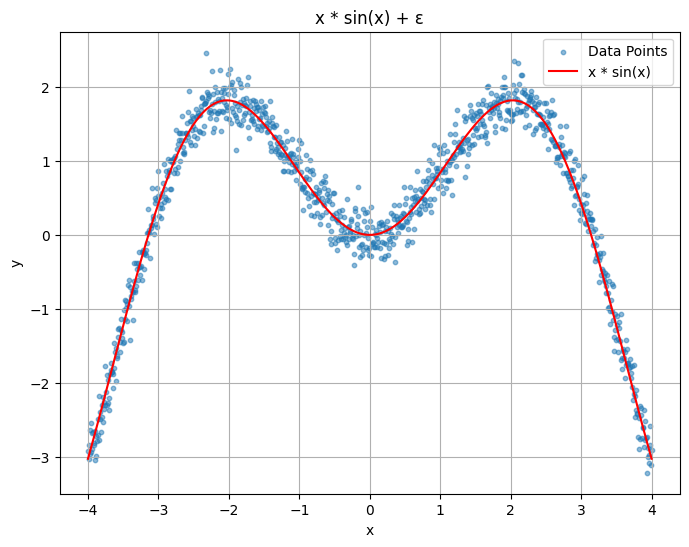

In [16]:
### Generate x * sin(x) dataset ###
np.random.seed(42)
X = np.linspace(-4, 4, 1000).reshape(-1, 1)
y = X.flatten() * np.sin(X.flatten()) + np.random.normal(0, 0.2, X.shape[0])

### Plot the Data ###
plt.figure(figsize=(8, 6))
plt.scatter(X, y, s=10, alpha=0.5, label='Data Points')
plt.plot(X, X.flatten() * np.sin(X.flatten()), color='red', label='x * sin(x)')
plt.title('x * sin(x) + ε')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

/Users/test/Development/Lafayette/French Thesis/lambda-linearity-score/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/Users/test/Development/Lafayette/French Thesis/lambda-linearity-score/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/Users/test/Development/Lafayette/French Thesis/lambda-linearity-score/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/Users/test/Development/Lafayette/French Thesis/lambda-linearity-score/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step


/Users/test/Development/Lafayette/French Thesis/lambda-linearity-score/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Experiment 1 Results:

Baseline Regression R^2:        -0.0080
Mean:                           -0.0080
Standard Deviation:             0.0000

Neural Network R^2:             0.9752
Mean:                           0.9751
Standard Deviation:             0.0003

Mimic Regression R^2:           -0.0139
Mean:                           -0.0141
Standard Deviation:             0.0003

Linearity Score λ(f):           -0.0110
Mean:                           -0.0108
Standard Deviation:             0.0004


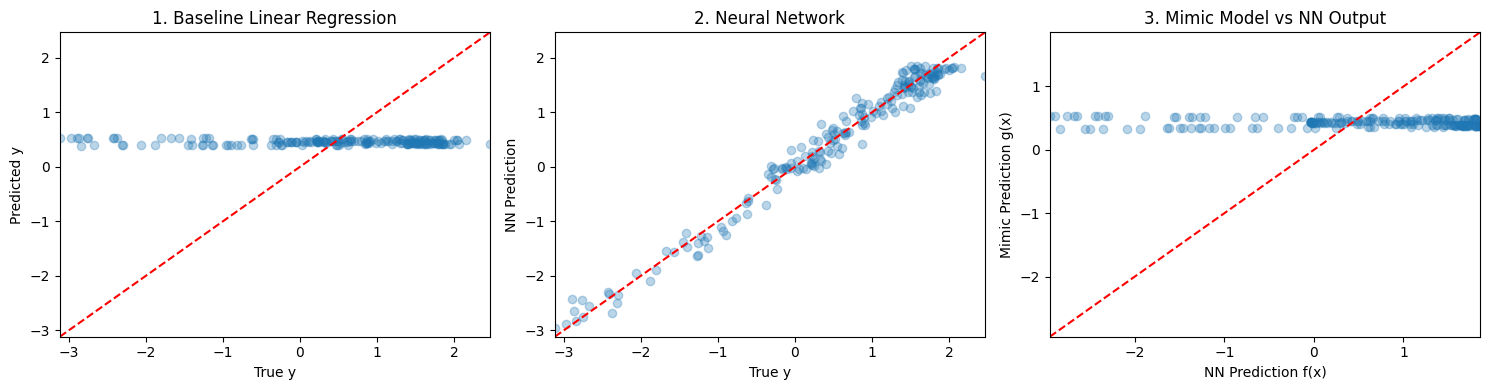

In [17]:
### Train/test split ###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standardize features ###
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Build network builder ###
def build_network():
    input_dim = X_train_scaled.shape[1]
    nn_model = Sequential([
        Dense(64, activation="relu", input_shape=(input_dim,)),
        Dense(64, activation="relu"),
        Dense(1, activation="linear")
    ])
    nn_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    return nn_model

### Run Experiment ###
results = run_experiment(X_train_scaled, y_train, X_test_scaled, y_test, build_network, n=5)

### Print Results ###
print("Experiment 1 Results:\n")

print(f"Baseline Regression R^2:        {results['baseline_scores'][0]:.4f}")
print(f"Mean:                           {results['baseline_mean']:.4f}")
print(f"Standard Deviation:             {results['baseline_sd']:.4f}\n")

print(f"Neural Network R^2:             {results['nn_scores'][0]:.4f}")
print(f"Mean:                           {results['nn_mean']:.4f}")
print(f"Standard Deviation:             {results['nn_sd']:.4f}\n")

print(f"Mimic Regression R^2:           {results['mimic_scores'][0]:.4f}")
print(f"Mean:                           {results['mimic_mean']:.4f}")
print(f"Standard Deviation:             {results['mimic_sd']:.4f}\n")

print(f"Linearity Score λ(f):           {results['lambda_scores'][0]:.4f}")
print(f"Mean:                           {results['lambda_mean']:.4f}")
print(f"Standard Deviation:             {results['lambda_sd']:.4f}")

### Plot a single run ###
plot_experiment_run(y_test, results['baseline_test_preds'][0],
                    results['nn_test_preds'][0], results['mimic_test_preds'][0])

## 4. Experiment 2: Medical Insurance Costs

In this experiment, we apply our linearity score $\lambda(f)$ to a real-world dataset of medical insurance charges. The dataset includes demographic and lifestyle features such as age, sex, body mass index (BMI), number of children, smoking status, and residential region. The target variable is charges, representing the total medical cost billed to each individual.

While the dataset contains some nonlinear interactions—particularly involving smoking status and BMI—much of its structure is linearly explainable. As a result, we expect:
- the baseline linear model to perform reasonably well,
- the neural network to capture additional nonlinear signal, and
- the linear surrogate to partially mimic the network's predictions, yielding a moderate $\lambda(f)$ score.

This experiment illustrates a middle-ground case, where linearity and nonlinearity coexist. It helps demonstrate how $\lambda(f)$ can quantify the degree of linear structure in a learned function, even when that structure is not perfect.

/var/folders/vg/zppfz3897czbp4qr3nqy74l40000gp/T/ipykernel_18890/357545410.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 54.3k/54.3k [00:00<00:00, 2.35MB/s]


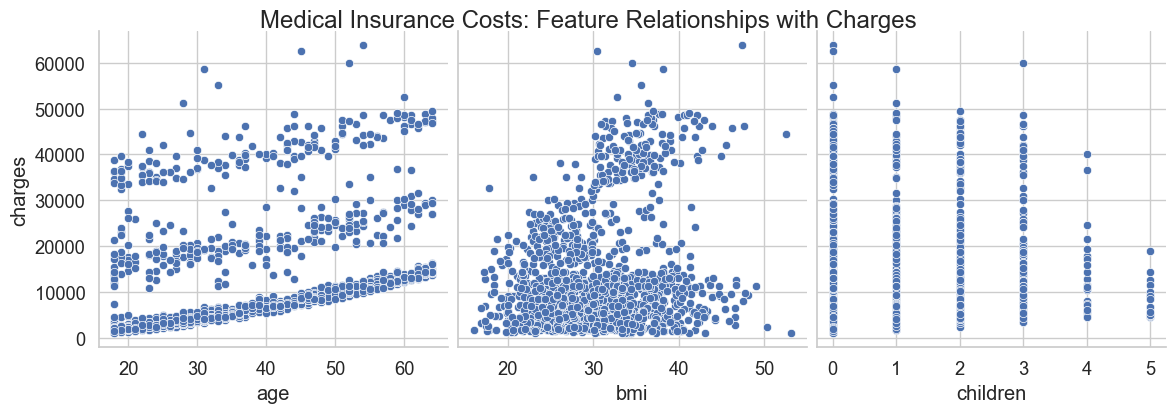

In [18]:
file_path = "insurance.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "mirichoi0218/insurance",
  file_path)

sns.set(style="whitegrid", font_scale=1.2)
sns.pairplot(df, x_vars=['age', 'bmi', 'children'], y_vars='charges', height=4, aspect=1, kind='scatter')
plt.suptitle('Medical Insurance Costs: Feature Relationships with Charges', y=1.02)
plt.show()

In [19]:
X = df.drop('charges', axis=1)  # Features
y = df['charges']               # Target variable

### Identify categorical and numerical columns ###
categorical_features = ['sex', 'smoker', 'region']
numerical_features = ['age', 'bmi', 'children']

### Preprocessing ###
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

X_processed = preprocessor.fit_transform(X)

### Train-test split ###
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

/Users/test/Development/Lafayette/French Thesis/lambda-linearity-score/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/Users/test/Development/Lafayette/French Thesis/lambda-linearity-score/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step


/Users/test/Development/Lafayette/French Thesis/lambda-linearity-score/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/test/Development/Lafayette/French Thesis/lambda-linearity-score/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/Users/test/Development/Lafayette/French Thesis/lambda-linearity-score/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
Experiment 2 Results:

Baseline Regression R^2:        0.7836
Mean:                           0.7836
Standard Deviation:             0.0000

Neural Network R^2:             0.8657
Mean:                           0.8662
Standard Deviation:             0.0025

Mimic Regression R^2:           0.7836
Mean:                           0.7833
Standard Deviation:             0.0004

Linearity Score λ(f):           0.9280
Mean:                           0.9225
Standard Deviation:             0.0045


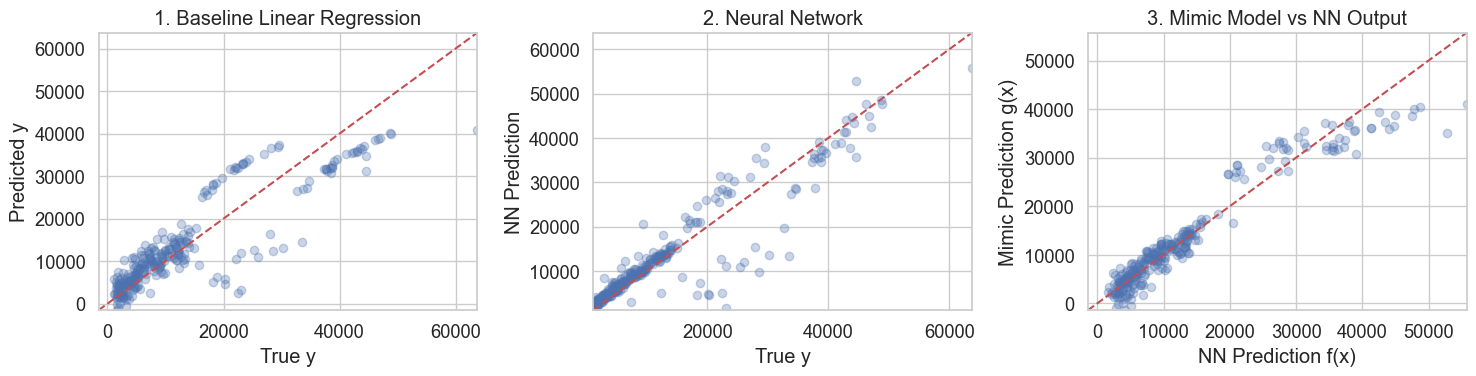

In [20]:

### Build network builder ###
def build_network():
    nn = Sequential([
        Dense(32, activation="relu", input_shape=(X_train.shape[1],)),
        Dense(16, activation="relu"),
        Dense(1)
    ])
    nn.compile(optimizer=Adam(learning_rate=0.01), loss="mse")
    return nn

### Run Experiment ###
results = run_experiment(X_train, y_train, X_test, y_test, build_network, n=5)

### Print Results ###
print("Experiment 2 Results:\n")

print(f"Baseline Regression R^2:        {results['baseline_scores'][0]:.4f}")
print(f"Mean:                           {results['baseline_mean']:.4f}")
print(f"Standard Deviation:             {results['baseline_sd']:.4f}\n")

print(f"Neural Network R^2:             {results['nn_scores'][0]:.4f}")
print(f"Mean:                           {results['nn_mean']:.4f}")
print(f"Standard Deviation:             {results['nn_sd']:.4f}\n")

print(f"Mimic Regression R^2:           {results['mimic_scores'][0]:.4f}")
print(f"Mean:                           {results['mimic_mean']:.4f}")
print(f"Standard Deviation:             {results['mimic_sd']:.4f}\n")

print(f"Linearity Score λ(f):           {results['lambda_scores'][0]:.4f}")
print(f"Mean:                           {results['lambda_mean']:.4f}")
print(f"Standard Deviation:             {results['lambda_sd']:.4f}")

### Plot a single run ###
plot_experiment_run(y_test, results['baseline_test_preds'][0],
                    results['nn_test_preds'][0], results['mimic_test_preds'][0])

## 5. **Experiment 3: California Housing**

In this experiment, we evaluate $\lambda(f)$ on the California Housing dataset, a standard real-world regression benchmark that predicts median house value from socioeconomic and geographic features such as income, population, and housing characteristics.

Unlike the controlled synthetic setting, this task exhibits heterogeneous structure and moderate nonlinearity. Neural networks are well suited to exploit such structure, but improved predictive performance does not guarantee that the learned function is linearly decodable. This makes California Housing a natural testbed for studying the relationship between accuracy and representational linearity.

To emulate distribution shift, we train models on the in-distribution portion of the data defined by the middle 80% of target values and evaluate both in-distribution and on the lower and upper 10% target tails. This setup allows us to examine how $\lambda(f)$ behaves under shift, where predictive accuracy and linear decodability may diverge.

Overall, this experiment illustrates how $\lambda(f)$ captures properties of a model’s learned representation that are not reflected by predictive performance alone.

*Note:* This experiment is more computationally intensive due to the size of the dataset.

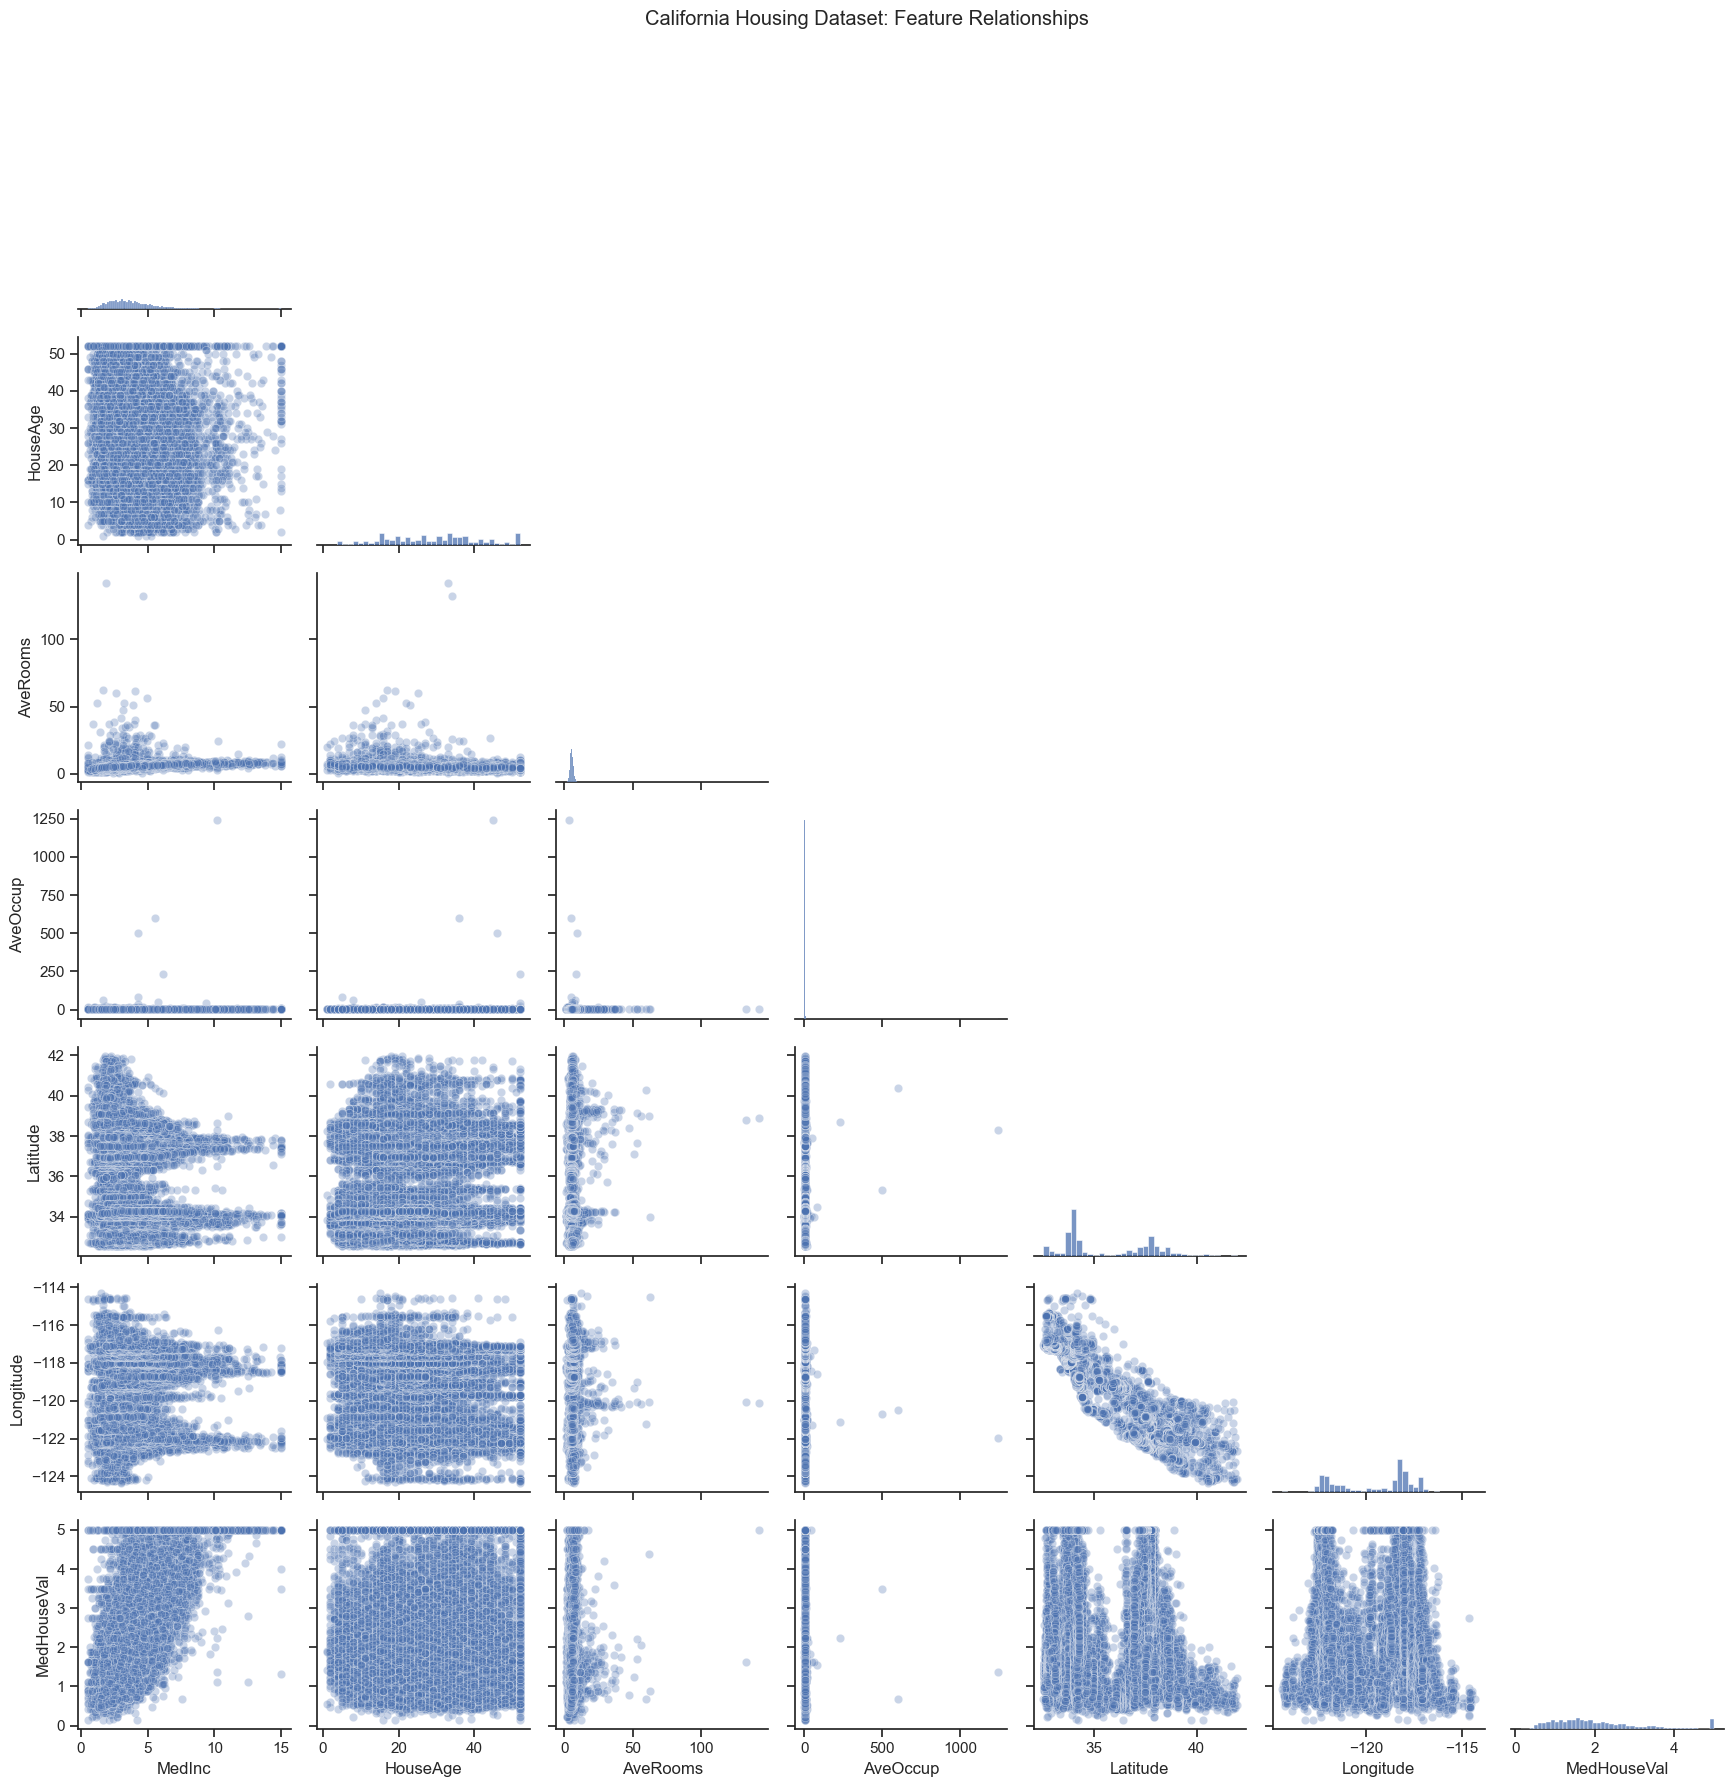

In [21]:
# Load dataset
data = fetch_california_housing(as_frame=True)
df = data.frame

# Select features to visualize
selected_features = [
    'MedInc', 'HouseAge', 'AveRooms', 'AveOccup',
    'Latitude', 'Longitude', 'MedHouseVal'
]

# Plot pairplot
sns.set(style="ticks", color_codes=True)
pairplot = sns.pairplot(df[selected_features], corner=True, plot_kws={'alpha': 0.3})
pairplot.fig.suptitle("California Housing Dataset: Feature Relationships", y=1.02)

plt.tight_layout()
plt.show()

/Users/test/Development/Lafayette/French Thesis/lambda-linearity-score/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


/Users/test/Development/Lafayette/French Thesis/lambda-linearity-score/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/test/Development/Lafayette/French Thesis/lambda-linearity-score/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step


/Users/test/Development/Lafayette/French Thesis/lambda-linearity-score/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/test/Development/Lafayette/French Thesis/lambda-linearity-score/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train on mid-80%, evaluate on low/mid/high
Thresholds (train): q10=1.9091, q90=6.1730
Counts: {'train_mid': 13208, 'test_mid': 3295, 'test_low': 435, 'test_high': 398}


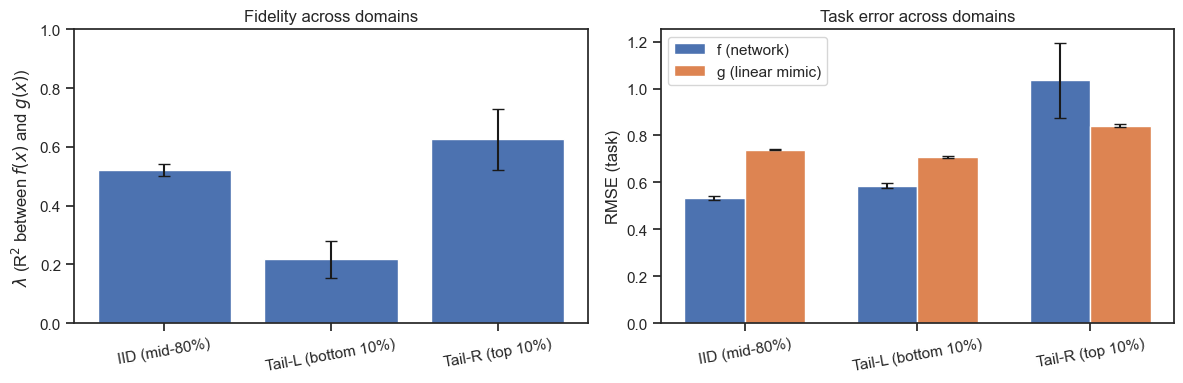

In [25]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# ---------------------------
# 1) Split: train on mid-80, eval on low/mid/high (thresholds from TRAIN y only)
# ---------------------------
def split_by_income_mid80(X_train, y_train, X_test, y_test, q=0.10):
    """
    Split by MedInc (feature 0), not by y.
    Thresholds computed on TRAIN MedInc only.
    """
    medinc_train = X_train[:, 0]
    lo = np.quantile(medinc_train, q)
    hi = np.quantile(medinc_train, 1 - q)

    train_mid = (medinc_train >= lo) & (medinc_train <= hi)

    test_medinc = X_test[:, 0]
    test_low  = (test_medinc < lo)
    test_mid  = (test_medinc >= lo) & (test_medinc <= hi)
    test_high = (test_medinc > hi)

    train = (X_train[train_mid], y_train[train_mid])
    tests = {
        "mid":  (X_test[test_mid],  y_test[test_mid]),
        "low":  (X_test[test_low],  y_test[test_low]),
        "high": (X_test[test_high], y_test[test_high]),
    }

    return (lo, hi), train, tests


# ---------------------------
# 2) Model builder
# ---------------------------
def build_network(input_dim):
    model = Sequential([
        Dense(64, activation="relu", input_shape=(input_dim,)),
        Dense(64, activation="relu"),
        Dense(1),
    ])
    model.compile(optimizer="adam", loss="mse")
    return model


# ---------------------------
# 3) Metric helpers
# ---------------------------
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def lambda_score_r2(f_vals, g_vals, eps=1e-12):
    """
    λ(f) = R^2 between f(x) and g(x), i.e., how well g predicts f.
    Uses a safety guard if var(f) is ~0 (R^2 would be undefined).
    """
    f_vals = np.asarray(f_vals).ravel()
    g_vals = np.asarray(g_vals).ravel()
    if np.var(f_vals) < eps:
        return 0.0
    return float(r2_score(f_vals, g_vals))


# ---------------------------
# 4) Train once, evaluate across domains
# ---------------------------
def run_mid80_train_eval3_domains(q=0.10, n=5, random_state=42, epochs=100, batch_size=32):
    data = fetch_california_housing()
    X, y = data.data, data.target

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    (lo, hi), (X_train_mid, y_train_mid), test_sets = split_by_income_mid80(
        X_train, y_train, X_test, y_test, q=q
    )

    # Standardize using ONLY mid-80 training data
    scaler = StandardScaler()
    X_train_mid_s = scaler.fit_transform(X_train_mid)
    test_sets_s = {k: (scaler.transform(Xk), yk) for k, (Xk, yk) in test_sets.items()}

    # Collect per-domain metrics over repetitions
    domains = ["mid", "low", "high"]
    hist = {
        d: {
            "lambda": [],
            "nn_rmse": [],
            "mimic_rmse": [],
            "baseline_rmse": [],
            # optionally keep preds from first run for debugging/plots
            "preds_first": None,
        }
        for d in domains
    }

    for rep in range(n):
        # ---- Baseline (trained once)
        baseline = LinearRegression()
        baseline.fit(X_train_mid_s, y_train_mid)

        # ---- NN f (trained once)
        nn = build_network(input_dim=X_train_mid_s.shape[1])
        nn.fit(X_train_mid_s, y_train_mid, epochs=epochs, batch_size=batch_size, verbose=0)

        # ---- Mimic g (trained once, on NN train outputs)
        f_train = nn.predict(X_train_mid_s).flatten()
        mimic = LinearRegression()
        mimic.fit(X_train_mid_s, f_train)

        # ---- Evaluate same models on each domain
        for d in domains:
            Xd, yd = test_sets_s[d]

            yhat_base = baseline.predict(Xd)
            f_test = nn.predict(Xd).flatten()
            g_test = mimic.predict(Xd)

            hist[d]["baseline_rmse"].append(rmse(yd, yhat_base))
            hist[d]["nn_rmse"].append(rmse(yd, f_test))
            hist[d]["mimic_rmse"].append(rmse(yd, g_test))
            hist[d]["lambda"].append(lambda_score_r2(f_test, g_test))

            if rep == 0:
                hist[d]["preds_first"] = {
                    "y_true": yd,
                    "baseline": yhat_base,
                    "f": f_test,
                    "g": g_test
                }

    # Summarize
    results = {
        "thresholds": {"q": q, "lo": float(lo), "hi": float(hi)},
        "counts": {
            "train_mid": int(len(y_train_mid)),
            "test_mid": int(len(test_sets["mid"][1])),
            "test_low": int(len(test_sets["low"][1])),
            "test_high": int(len(test_sets["high"][1])),
        },
        "splits": {}
    }

    for d in domains:
        results["splits"][d] = {
            "lambda_scores": hist[d]["lambda"],
            "lambda_mean": float(np.mean(hist[d]["lambda"])),
            "lambda_sd": float(np.std(hist[d]["lambda"])),

            "nn_rmse_scores": hist[d]["nn_rmse"],
            "nn_rmse_mean": float(np.mean(hist[d]["nn_rmse"])),
            "nn_rmse_sd": float(np.std(hist[d]["nn_rmse"])),

            "mimic_rmse_scores": hist[d]["mimic_rmse"],
            "mimic_rmse_mean": float(np.mean(hist[d]["mimic_rmse"])),
            "mimic_rmse_sd": float(np.std(hist[d]["mimic_rmse"])),

            "baseline_rmse_scores": hist[d]["baseline_rmse"],
            "baseline_rmse_mean": float(np.mean(hist[d]["baseline_rmse"])),
            "baseline_rmse_sd": float(np.std(hist[d]["baseline_rmse"])),

            "preds_first": hist[d]["preds_first"],
        }

    return results


# ---------------------------
# 5) Plot
# ---------------------------
def plot_domain_bars_reference(results):
    domains = [
        ("IID (mid-80%)", "mid"),
        ("Tail-L (bottom 10%)", "low"),
        ("Tail-R (top 10%)", "high"),
    ]
    labels = [lbl for lbl, _ in domains]
    keys   = [k for _, k in domains]

    lambda_means = [results["splits"][k]["lambda_mean"] for k in keys]
    lambda_sds   = [results["splits"][k]["lambda_sd"]   for k in keys]

    nn_rmse_means = [results["splits"][k]["nn_rmse_mean"] for k in keys]
    nn_rmse_sds   = [results["splits"][k]["nn_rmse_sd"]   for k in keys]

    mimic_rmse_means = [results["splits"][k]["mimic_rmse_mean"] for k in keys]
    mimic_rmse_sds   = [results["splits"][k]["mimic_rmse_sd"]   for k in keys]

    x = np.arange(len(labels))
    width = 0.35

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Left: Fidelity (lambda)
    axes[0].bar(x, lambda_means, yerr=lambda_sds, capsize=4)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(labels, rotation=10)
    axes[0].set_ylabel(r"$\lambda$ (R$^2$ between $f(x)$ and $g(x)$)")
    axes[0].set_title("Fidelity across domains")
    axes[0].set_ylim(0, 1)

    # Right: Task error (RMSE)
    axes[1].bar(x - width/2, nn_rmse_means, width, yerr=nn_rmse_sds, capsize=4, label="f (network)")
    axes[1].bar(x + width/2, mimic_rmse_means, width, yerr=mimic_rmse_sds, capsize=4, label="g (linear mimic)")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(labels, rotation=10)
    axes[1].set_ylabel("RMSE (task)")
    axes[1].set_title("Task error across domains")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


# ---------------------------
# 6) Run + plot
# ---------------------------
results = run_mid80_train_eval3_domains(q=0.10, n=5, random_state=42, epochs=100)
print("Train on mid-80%, evaluate on low/mid/high")
print(f"Thresholds (train): q10={results['thresholds']['lo']:.4f}, q90={results['thresholds']['hi']:.4f}")
print("Counts:", results["counts"])

plot_domain_bars_reference(results)

## 7. Conclusion

In this notebook, we demonstrated how to use the linearity score $\lambda(f)$ to evaluate the linear decodability of neural network regressors across a variety of datasets. Our experiments showed that:

- A high $\lambda(f)$ score indicates that a neural network's outputs can be closely mimicked by a linear model.
- However, this does **not** guarantee that the model is accurate with respect to the ground truth.
- In fact, even perfect mimicry of a poorly performing network offers little practical value.

These findings support the central thesis of the paper: **fidelity is not accuracy**. $\lambda(f)$ is a useful diagnostic tool—but it must be interpreted carefully.


### For More Detail
Refer to the full paper (*Fidelity Isn’t Accuracy*) for theoretical discussion and recommendations on using linear surrogates in practice.


### Feedback?
If you find this notebook useful or have suggestions, feel free to reach out ([eshbaugj@lafayette.edu](mailto:eshbaugj@lafayette.edu); [jacksoneshbaugh.github.io](https://jacksoneshbaugh.github.io)) or cite the work!

<center><i>This notebook accompanies the paper</i> <b>Fidelity Isn't Accuracy</b>, <i>by Jackson Eshbaugh.</i></center>
<center>&copy; 2026 Jackson Eshbaugh &bull; Lafayette College &bull; Department of Computer Science</center>